In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
import numpy as np
from Modules.sympy.classes import *
from Modules.sympy.utils import *

from Modules.sympy.untruncated.solver import *

# Plot Params

In [3]:
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=14)

# Elliptical Quantum Well

In [4]:
dim_finite = 1
dim_x = 5
dim_y = 5
Finite = RDBasis("1", 'finite', dim = dim_finite)

ax = RDBoson("{a_x}", subspace ="x", dim_projection = dim_x)
adx = RDBoson("{a_x^\\dagger}", subspace ="x", is_annihilation=False, dim_projection = dim_x)
ay = RDBoson("{a_y}", subspace ="y", dim_projection = dim_y)
ady = RDBoson("{a_y^\\dagger}", subspace ="y", is_annihilation=False, dim_projection = dim_y)

subspaces = [[Finite.subspace, dim_finite], [ax.subspace, dim_x], [ay.subspace, dim_y]]

commutation_relations = {
    ax * adx : adx * ax + 1,
    ay * ady : ady * ay + 1,
    ay * adx : adx * ay,
    ady * ax : ax * ady,
    ay * ax : ax * ay,
    ady * adx : adx * ady,
    Finite._basis[0] : 1
}

Omega_x = RDsymbol("\\Omega_{x}", order = 0) # Omega_x**2 = omega_x**2 + omega_c**2/4, omega_c = e * B / m
Omega_y = RDsymbol("\\Omega_{y}", order = 0) # Omega_y**2 = omega_y**2 + omega_c**2/4

g1 = RDsymbol("g_1", order = 1) # omega_c * sqrt(Omega_x / Omega_y)
g2 = RDsymbol("g_2", order = 1) # omega_c * sqrt(Omega_y / Omega_x)

hbar = RDsymbol("hbar", order = 0)

H0 = (sp.Rational(1,2) * hbar * Omega_x * (adx * ax + ax*adx) + sp.Rational(1,2) * hbar * Omega_y * (ady * ay + ay * ady)).expand()
display(H0)
V = (sp.Rational(1,4) * hbar * sp.I * ( g1* (adx - ax)  * (ady + ay) - g2 * (adx + ax) * (ady - ay) )).expand()
display(V)

H = H0 + V
display(H)

\Omega_{x}*hbar*{a_x^\dagger}*{a_x}/2 + \Omega_{x}*hbar*{a_x}*{a_x^\dagger}/2 + \Omega_{y}*hbar*{a_y^\dagger}*{a_y}/2 + \Omega_{y}*hbar*{a_y}*{a_y^\dagger}/2

I*g_1*hbar*{a_x^\dagger}*{a_y^\dagger}/4 + I*g_1*hbar*{a_x^\dagger}*{a_y}/4 - I*g_1*hbar*{a_x}*{a_y^\dagger}/4 - I*g_1*hbar*{a_x}*{a_y}/4 - I*g_2*hbar*{a_x^\dagger}*{a_y^\dagger}/4 + I*g_2*hbar*{a_x^\dagger}*{a_y}/4 - I*g_2*hbar*{a_x}*{a_y^\dagger}/4 + I*g_2*hbar*{a_x}*{a_y}/4

\Omega_{x}*hbar*{a_x^\dagger}*{a_x}/2 + \Omega_{x}*hbar*{a_x}*{a_x^\dagger}/2 + \Omega_{y}*hbar*{a_y^\dagger}*{a_y}/2 + \Omega_{y}*hbar*{a_y}*{a_y^\dagger}/2 + I*g_1*hbar*{a_x^\dagger}*{a_y^\dagger}/4 + I*g_1*hbar*{a_x^\dagger}*{a_y}/4 - I*g_1*hbar*{a_x}*{a_y^\dagger}/4 - I*g_1*hbar*{a_x}*{a_y}/4 - I*g_2*hbar*{a_x^\dagger}*{a_y^\dagger}/4 + I*g_2*hbar*{a_x^\dagger}*{a_y}/4 - I*g_2*hbar*{a_x}*{a_y^\dagger}/4 + I*g_2*hbar*{a_x}*{a_y}/4

# Analytical Solution

In [5]:
hbar_val = 1.0545718 * 1e-34
e = 1.60217662 * 1e-19
m_0= 9.10938356 * 1e-31
m = m_0 * 0.19 # Effective mass of the electron in Silicon

def omega_1(omega_x, omega_y, B):
    # Analytical solution for omega_1
    omega_c = e * B / m
    return 1/np.sqrt(2) * np.sqrt(omega_x**2 + omega_y**2 + omega_c**2 + np.sqrt((omega_x**2 - omega_y**2)**2 + 2 *omega_c**2 * (omega_x**2 + omega_y**2) + omega_c**4))

def omega_2(omega_x, omega_y, B):
    # Analytical solution for omega_2
    omega_c = e * B / m
    return 1/np.sqrt(2) * np.sqrt(omega_x**2 + omega_y**2 + omega_c**2 - np.sqrt((omega_x**2 - omega_y**2)**2 + 2 *omega_c**2 * (omega_x**2 + omega_y**2) + omega_c**4))

def get_num_energy(omega_x, omega_y, B, nx, ny):
    # Analytical solution for the Hamiltonian
    o1 = omega_1(omega_x, omega_y, B)
    o2 = omega_2(omega_x, omega_y, B)
    return 1/2 * hbar_val * ( o1 + o2 ) + hbar_val * o1 * nx  + hbar_val * o2 * ny


# Compare the analytical perturmation solution with the numerical solution

## Untruncated Solver

In [6]:
def get_an_energy(H_sol, omega_x, omega_y, B):
    # Obtain the solution for the Hamiltonian using the perturbative approach
    omega_c = e * B / m
    subs_gs = {
        hbar : hbar_val,
        g1 : omega_c * sp.sqrt(Omega_x / Omega_y),
        g2 : omega_c * sp.sqrt(Omega_y / Omega_x)
    }
    subs_Omegas = {
        Omega_x : np.sqrt(omega_x**2 + omega_c**2/4),
        Omega_y : np.sqrt(omega_y**2 + omega_c**2/4)
    }

    H_mat = H_sol.subs(subs_gs).subs(subs_Omegas)
    return np.sort(np.array(list(H_mat.diagonal())))

In [7]:
max_order = 4
error_E00_full = []
error_E01_full = []
error_E10_full = []

error_E00_block = []
error_E01_block = []
error_E10_block = []

lx = 60e-9
ly = 70e-9

omega_x = hbar_val / (m * lx**2)
omega_y = hbar_val / (m * ly**2)
B_val = 0.01 # np.linspace(0.01, 0.05, 100)

E00_n = get_num_energy(omega_x, omega_y, B_val, 0, 0)
E01_n = get_num_energy(omega_x, omega_y, B_val, 0, 1)
E10_n = get_num_energy(omega_x, omega_y, B_val, 1, 0)


for order in range(1, max_order+1):

    sol = solver(H, Finite, order=order, full_diagonal=True, commutation_relations=commutation_relations)
    H_mat = get_matrix(sol[0], subspaces)
    H_mat_a = get_an_energy(H_mat, omega_x, omega_y, B_val)
    E00_a, E01_a, E10_a = H_mat_a[0:3]


    error_E00_full.append(np.abs((E00_n - E00_a) / E00_n))
    error_E01_full.append(np.abs((E01_n - E01_a) / E01_n))
    error_E10_full.append(np.abs((E10_n - E10_a) / E10_n))


    sol = solver(H, Finite, order=order, full_diagonal=False, commutation_relations=commutation_relations)
    H_mat = get_matrix(sol[0], subspaces)
    H_mat_a = get_an_energy(H_mat, omega_x, omega_y, B_val)
    E00_a, E01_a, E10_a = H_mat_a[0:3]
    
    error_E00_block.append(np.abs((E00_n - E00_a) / E00_n))
    error_E01_block.append(np.abs((E01_n - E01_a) / E01_n))
    error_E10_block.append(np.abs((E10_n - E10_a) / E10_n))


100%|██████████| 30/30 [00:52<00:00,  1.76s/it]


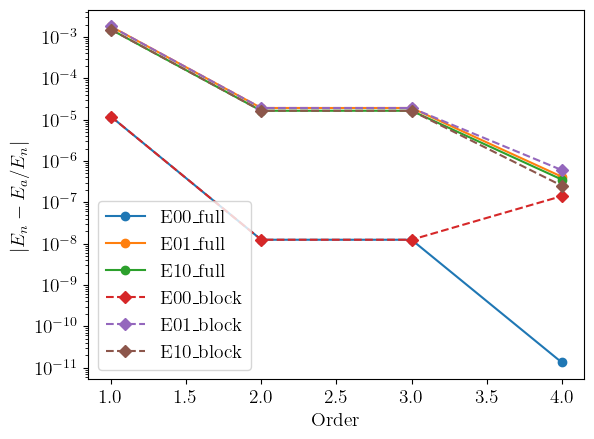

In [8]:
fig, ax_ = plt.subplots()

ax_.plot(range(1, max_order+1), error_E00_full, label = "E00_full", marker='o')
ax_.plot(range(1, max_order+1), error_E01_full, label = "E01_full", marker='o')
ax_.plot(range(1, max_order+1), error_E10_full, label = "E10_full", marker='o')


ax_.plot(range(1, max_order+1), error_E00_block, label = "E00_block", linestyle='dashed', marker='D')
ax_.plot(range(1, max_order+1), error_E01_block, label = "E01_block", linestyle='dashed', marker='D')
ax_.plot(range(1, max_order+1), error_E10_block, label = "E10_block", linestyle='dashed', marker='D')

ax_.set_yscale('log')
ax_.set_xlabel("Order")
ax_.set_ylabel(r"$|E_n - E_a/E_n|$")
ax_.legend()

## Truncated Solver

In [10]:
from Modules.sympy.truncated.solver import solver as solver_truncated

max_order = 4
error_E00_full = []
error_E01_full = []
error_E10_full = []

error_E00_block = []
error_E01_block = []
error_E10_block = []

lx = 60e-9
ly = 70e-9

omega_x = hbar_val / (m * lx**2)
omega_y = hbar_val / (m * ly**2)
B_val = 0.01 # np.linspace(0.01, 0.05, 100)

E00_n = get_num_energy(omega_x, omega_y, B_val, 0, 0)
E01_n = get_num_energy(omega_x, omega_y, B_val, 0, 1)
E10_n = get_num_energy(omega_x, omega_y, B_val, 1, 0)


omega_c = e * B_val / m

subs_Omegas = {
    Omega_x : sp.sqrt(omega_x**2 + omega_c**2/4),
    Omega_y : sp.sqrt(omega_y**2 + omega_c**2/4)
}

display_dict(subs_Omegas)

H_subs = H.subs(subs_Omegas)

for order in range(1, max_order+1):

    sol = solver_truncated(H_subs, subspaces, order=order, full_diagonal=True)
    H_mat_a = get_an_energy(sol[0], omega_x, omega_y, B_val)
    E00_a, E01_a, E10_a = H_mat_a[0:3]


    error_E00_full.append(np.abs((E00_n - E00_a) / E00_n))
    error_E01_full.append(np.abs((E01_n - E01_a) / E01_n))
    error_E10_full.append(np.abs((E10_n - E10_a) / E10_n))


    sol = solver_truncated(H, subspaces, order=order, full_diagonal=False)
    H_mat_a = get_an_energy(sol[0], omega_x, omega_y, B_val)
    E00_a, E01_a, E10_a = H_mat_a[0:3]
    
    error_E00_block.append(np.abs((E00_n - E00_a) / E00_n))
    error_E01_block.append(np.abs((E01_n - E01_a) / E01_n))
    error_E10_block.append(np.abs((E10_n - E10_a) / E10_n))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 30/30 [00:34<00:00,  1.14s/it]


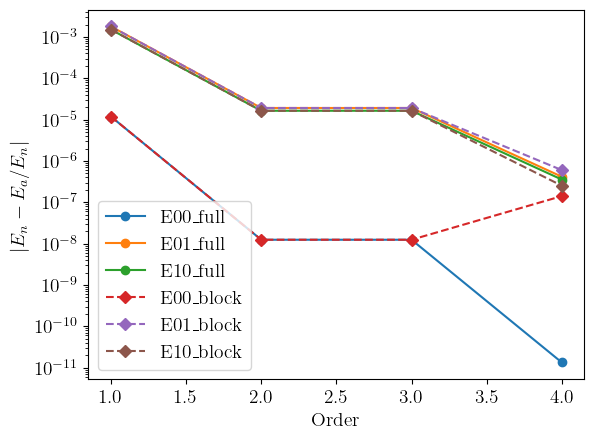

In [ ]:
fig, ax_ = plt.subplots()

ax_.plot(range(1, max_order+1), error_E00_full, label = "E00_full", marker='o')
ax_.plot(range(1, max_order+1), error_E01_full, label = "E01_full", marker='o')
ax_.plot(range(1, max_order+1), error_E10_full, label = "E10_full", marker='o')


ax_.plot(range(1, max_order+1), error_E00_block, label = "E00_block", linestyle='dashed', marker='D')
ax_.plot(range(1, max_order+1), error_E01_block, label = "E01_block", linestyle='dashed', marker='D')
ax_.plot(range(1, max_order+1), error_E10_block, label = "E10_block", linestyle='dashed', marker='D')

ax_.set_yscale('log')
ax_.set_xlabel("Order")
ax_.set_ylabel(r"$|E_n - E_a/E_n|$")
ax_.legend()